references: https://huggingface.co/blog/fine-tune-vit
            

---

https://medium.com/@supersjgk/fine-tuning-vision-transformer-with-hugging-face-and-pytorch-df19839d5396

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="f32xFqYKZCtMrVK7IGmM")
project = rf.workspace("potatao-weeds").project("sesame-weed-detection")
version = project.version(2)
dataset = version.download("yolov8")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.2 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to sesame-weed-detection-2 in yolov8:: 100%|██████████| 2609/2609 [00:00<00:00, 3345.73it/s]


In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import shutil
import random
import pandas as pd

In [ ]:
train_images_folder = '/content/sesame-weed-detection-2/train/images'
test_images_folder = '/content/sesame-weed-detection-2/test/images'
train_labels_folder = '/content/sesame-weed-detection-2/train/labels'
test_labels_folder = '/content/sesame-weed-detection-2/test/labels'

In [ ]:
train_images = os.listdir(train_images_folder)
test_images = os.listdir(test_images_folder)
num_train_images = len(train_images)
num_test_images = len(test_images)
print('no. of train images = ' + str(len(train_images)))

no. of train images = 1210


In [ ]:
train_labels_dict = {}
test_labels_dict = {}

for i in range(num_train_images):
  image_path = os.path.join(train_images_folder, train_images[i])
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  label_path = os.path.join(train_labels_folder, train_images[i].replace('.jpg', '.txt'))
  with open(label_path, 'r') as f:
    labels = f.readlines()

  class_id, x, y, width, height = map(float, labels[0].strip().split())
  class_id = int(class_id)
  train_labels_dict[image_path] = class_id

for i in range(num_test_images):
  image_path = os.path.join(test_images_folder, test_images[i])
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  label_path = os.path.join(test_labels_folder, test_images[i].replace('.jpg', '.txt'))
  with open(label_path, 'r') as f:
    labels = f.readlines()

  class_id, x, y, width, height = map(float, labels[0].strip().split())
  class_id = int(class_id)
  test_labels_dict[image_path] = class_id

train_labels_df = pd.DataFrame(list(train_labels_dict.items()), columns=['image_path', 'class_id'])
test_labels_df = pd.DataFrame(list(test_labels_dict.items()), columns=['image_path', 'class_id'])

In [ ]:
train_labels_df['class_id'].value_counts()

,count
class_id,
1,620
0,590


In [ ]:
crops = train_labels_df[train_labels_df['class_id'] == 0]
weeds = train_labels_df[train_labels_df['class_id'] == 1]

sampled_crops = crops.sample(n=200, random_state=7)
sampled_weeds = weeds.sample(n=200, random_state=7)

sampled_df = pd.concat([sampled_crops, sampled_weeds]).sample(frac=1, random_state=7).reset_index(drop=True)

In [ ]:
output_folder = '/content/dataset'

def create_dirs(base_folder, categories):
    for category in categories:
      for split in ['train', 'test']:
        category_folder = os.path.join(base_folder, split, category)
        if os.path.exists(category_folder):
          shutil.rmtree(category_folder)
        os.makedirs(category_folder, exist_ok=True)

create_dirs(output_folder, ['crop', 'weed'])

In [ ]:
def copy_images(labels_df, dest_folder):
    for index, row in labels_df.iterrows():
      image_path = row['image_path']
      label = 'crop' if row['class_id'] == 0 else 'weed'
      dest_path = os.path.join(dest_folder, label)
      shutil.copy2(image_path, dest_path)

copy_images(train_labels_df, os.path.join(output_folder, 'train'))
copy_images(test_labels_df, os.path.join(output_folder, 'test'))

In [ ]:
len(os.listdir('/content/dataset/train/weed'))

620

**When we have enough labelled data**

In [ ]:
! pip install transformers lightning transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10

In [ ]:
import torch
import torchvision
from torchvision.transforms import Normalize, Resize, ToTensor, Compose, ToPILImage
from transformers import ViTFeatureExtractor, ViTForImageClassification, ViTImageProcessor, Trainer
from datasets import load_dataset
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
dataset = load_dataset('imagefolder', data_dir='/content/dataset')
dataset

Resolving data files:   0%|          | 0/1210 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/90 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1210
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 90
    })
})

In [ ]:
print(dataset['train'].features)
print(dataset['train'].num_rows)
print(dataset['train'][0])

{'image': Image(mode=None, decode=True, id=None), 'label': ClassLabel(names=['crop', 'weed'], id=None)}
1210
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7DC016162050>, 'label': 0}


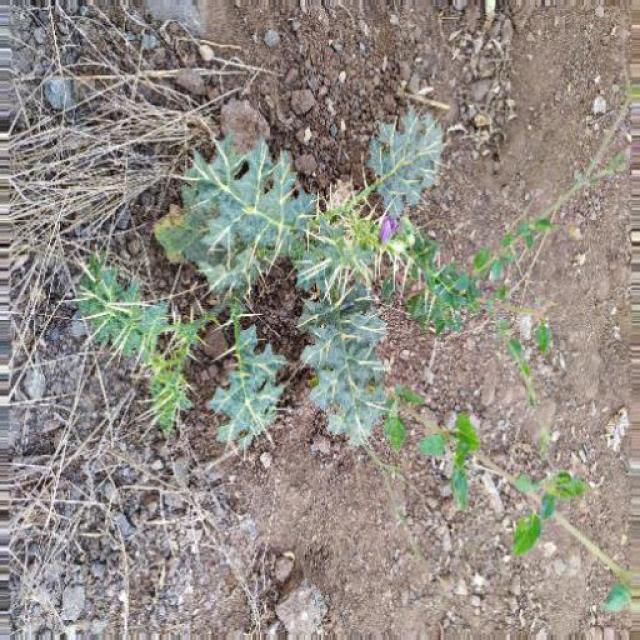

In [ ]:
dataset['train'][600]['image']

In [ ]:
labels = dataset['train'].features['label']
labels.int2str(dataset['train'][600]['label'])

'weed'

In [ ]:
model_name_or_path = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_name_or_path)


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [ ]:
processor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [ ]:
def process_example(example):
    inputs = processor(example['image'], return_tensors='pt')
    inputs['label'] = example['label']
    return inputs

process_example(dataset['train'][0])

{'pixel_values': tensor([[[[-0.0980, -0.0824, -0.0353,  ...,  0.5686,  0.6314,  0.6392],
          [ 0.0431,  0.0353, -0.0431,  ...,  0.6627,  0.4902,  0.4510],
          [ 0.0118, -0.0039, -0.0118,  ...,  0.2078,  0.2235,  0.2235],
          ...,
          [-0.0431, -0.0510, -0.0745,  ..., -0.0745, -0.2235, -0.2314],
          [-0.5608, -0.5843, -0.6314,  ...,  0.0039, -0.0667, -0.0745],
          [-0.6078, -0.5843, -0.4588,  ..., -0.3647, -0.5216, -0.5137]],

         [[-0.2235, -0.2078, -0.1608,  ...,  0.4353,  0.5059,  0.4980],
          [-0.0824, -0.0902, -0.1686,  ...,  0.5059,  0.3333,  0.2863],
          [-0.1137, -0.1294, -0.1373,  ...,  0.0275,  0.0431,  0.0353],
          ...,
          [-0.1294, -0.1451, -0.1686,  ..., -0.1922, -0.3412, -0.3490],
          [-0.6863, -0.7020, -0.7333,  ..., -0.1216, -0.1922, -0.2000],
          [-0.7490, -0.7176, -0.5765,  ..., -0.4902, -0.6471, -0.6392]],

         [[-0.3490, -0.3333, -0.2863,  ...,  0.2549,  0.2784,  0.2627],
          [-0

In [ ]:
def transform(example_batch):
    inputs = processor([x for x in example_batch['image']], return_tensors='pt')
    inputs['label'] = example_batch['label']
    return inputs

prepared_ds = dataset.with_transform(transform)

In [ ]:
prepared_ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1210
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 90
    })
})

In [ ]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

In [ ]:
labels = dataset['train'].features['label'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-weed-detection",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)


`evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["test"],
    tokenizer=processor,
)

`tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.


In [ ]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Step,Training Loss,Validation Loss,Accuracy
100,0.113000,0.022030,1.000000
200,0.137800,0.026723,1.000000
300,0.057400,0.024648,1.000000


***** train metrics *****
  epoch                    =         4.0
  total_flos               = 349302990GF
  train_loss               =      0.1324
  train_runtime            =  0:02:07.00
  train_samples_per_second =      38.108
  train_steps_per_second   =       2.394


In [ ]:
metrics = trainer.evaluate(prepared_ds['test'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =        1.0
  eval_loss               =      0.022
  eval_runtime            = 0:00:03.09
  eval_samples_per_second =     29.068
  eval_steps_per_second   =      3.876
